In [10]:
#!/usr/bin/env python3
import sys
import requests

import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy import optimize

from sgp4.api import Satrec

import astropy.units as u
from astropy.io import ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord, FK5, GCRS, EarthLocation, AltAz
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, TEME

import lofarantpos
from lofarantpos.db import LofarAntennaDatabase

if __name__ == "__main__":
    # Input settings
    sourcefname = "sources.csv"
    tstart_isot = "2022-12-09T12:00:00"
    duration_s = 12*60*60
#    satno = 33591
#    satno = 25338
#    satno = 28654
    satno = 40069

    # Satellites
    # NOAA 15:    25338 APT at 137.620MHz
    # NOAA 18:    28654 APT at 137.912MHz
    # NOAA 19:    33591 APT at 137.100MHz
    # Meteor M-2: 40069 LRPT at 137.100MHz
    
    # Read sources
    d = ascii.read(sourcefname, format="csv")
    psrc = SkyCoord(ra=d["ra"], dec=d["dec"], unit=("hourangle", "deg"), frame="icrs")
    names = d["name"]
    
    # Compute satellite passes
    t = Time(tstart_isot, format="isot", scale="utc") + np.arange(duration_s) * u.s
    
    # Download TLE
    resp = requests.get(f"http://celestrak.org/NORAD/elements/gp.php?CATNR={satno:05d}")
    lines = resp.content.decode("utf-8").splitlines()

    # Satellite position and velocity
    sat = Satrec.twoline2rv(lines[1], lines[2])
    _, teme_p, teme_v = sat.sgp4_array(t.jd1, t.jd2)
    teme_p = CartesianRepresentation(teme_p.T*u.km)
    teme = TEME(teme_p, obstime=t)

    # Reference location
    db = LofarAntennaDatabase()
    loc = EarthLocation.from_geocentric(*(db.phase_centres["CS001HBA0"] * u.m))
    
    # To altaz
    gloc = loc.get_gcrs(obstime=t)
    g = teme.transform_to(GCRS(obstime=t, obsgeoloc=gloc.cartesian))
    a = teme.transform_to(AltAz(obstime=t, location=loc))

    # Find maximum pass
    idx = np.argmax(a.alt.degree)
    tmax = t[idx]
    amax = a[idx].alt.degree
    dt = 600 * u.s
    if amax < 60:
        print("No passes above 60 degrees found")
        sys.exit()
    print("altmax %s %.1f @ %.3f %.3f"%(t[idx].isot,amax,a[idx].az.degree,a[idx].alt.degree))
    # Select points above altitude limit
    c = (a.alt.degree > 30) & (np.abs((t - tmax).to(u.s)) < dt)

    # Loop over sources
    for p, name in zip(psrc, names):
        # Setup interpolating functions
        fdec = interpolate.interp1d(t[c].mjd, g[c].dec.degree - p.dec.degree)
        faz = interpolate.interp1d(t[c].mjd, a[c].az.degree)
        falt = interpolate.interp1d(t[c].mjd, a[c].alt.degree)

        # Time extrema
        tmin, tmax = np.min(t[c]), np.max(t[c])
        print(name,tmin,tmax)
        # Find pass
        mjdpass = optimize.bisect(fdec, tmin.mjd, tmax.mjd)
        tpass = Time(mjdpass, format="mjd")
        apass = AltAz(az=faz(mjdpass) * u.deg, alt=falt(mjdpass) * u.deg, obstime=tpass, location=loc)
        gpass = apass.transform_to(GCRS(obstime=tpass))

        sra = gpass.ra.to_string(unit="hourangle", sep=":", precision=2, pad=True)
        sdec = gpass.dec.to_string(unit="deg", sep=":", precision=1, alwayssign=True, pad=True)
        
        print(f"{name} {tpass.isot} {apass.az.degree:7.3f} {apass.alt.degree:6.3f} {sra} {sdec}")


altmax 2022-12-09T16:43:42.000 61.8 @ 69.180 61.823
Cas A 2022-12-09T16:41:07.000 2022-12-09T16:46:18.000
Cas A 2022-12-09T16:43:54.351  57.219 61.308 01:49:15.90 +58:48:52.8
Cyg A 2022-12-09T16:41:07.000 2022-12-09T16:46:18.000
Cyg A 2022-12-09T16:43:13.141  95.420 58.964 01:13:57.16 +40:44:02.2
Tau A 2022-12-09T16:41:07.000 2022-12-09T16:46:18.000
Tau A 2022-12-09T16:42:25.535 121.532 47.630 00:55:36.48 +22:00:48.2


In [14]:
tstart_isot = "2022-12-09T12:00:00"
duration_s = 12*60*60
    
# Compute satellite passes
t = Time(tstart_isot, format="isot", scale="utc") + np.arange(duration_s) * u.s


In [15]:
# Reference location
db = LofarAntennaDatabase()
loc = EarthLocation.from_geocentric(*(db.phase_centres["CS001HBA0"] * u.m))


In [12]:
sat_ids0=[25338,28654,33591,40069]
from satellite_tle import fetch_latest_tles
sat_tles=fetch_latest_tles(sat_ids0)
print(sat_tles)

{25338: ('Celestrak (SatNOGS)', ('NOAA 15', '1 25338U 98030A   22343.04228904  .00000167  00000+0  87727-4 0  9992', '2 25338  98.6274  10.1577 0011021 144.2569 215.9350 14.26205243278153')), 28654: ('Celestrak (SatNOGS)', ('NOAA 18', '1 28654U 05018A   22343.06552301  .00000225  00000+0  14509-3 0  9995', '2 28654  98.9325  53.2142 0014152 194.2771 165.8003 14.12818533904725')), 33591: ('Celestrak (SatNOGS)', ('NOAA 19', '1 33591U 09005A   22343.01602761  .00000183  00000+0  12341-3 0  9997', '2 33591  99.1278  20.6556 0014653  60.0974 300.1651 14.12648177713095')), 40069: ('Celestrak (SatNOGS)', ('METEOR-M 2', '1 40069U 14037A   22343.12289667  .00000026  00000+0  31356-4 0  9998', '2 40069  98.4269 352.9175 0005870 164.0406 196.0957 14.20729037436669'))}


In [27]:
# Satellite position and velocity
altaz=[]
for satid in sat_ids0:
    lines=sat_tles[satid][1]
    sat = Satrec.twoline2rv(lines[1], lines[2])
    _, teme_p, teme_v = sat.sgp4_array(t.jd1, t.jd2)
    teme_p = CartesianRepresentation(teme_p.T*u.km)
    teme = TEME(teme_p, obstime=t)
    
    # To altaz
    gloc = loc.get_gcrs(obstime=t)
#    g = teme.transform_to(GCRS(obstime=t, obsgeoloc=gloc.cartesian))
    a = teme.transform_to(AltAz(obstime=t, location=loc))
    altaz.append(a)

In [66]:
flyovers=[]
Nsat=len(sat_ids0)
for i in range(Nsat):
    alt=altaz[i].alt.degree
    grad=alt[1:]-alt[:-1]
    peak=(grad[:-1]>0)*(grad[1:]<0)*(alt[1:-1]>40)#40
    peak_index=np.compress(peak,np.array(range(len(peak))))+1
    for x in peak_index:
        flyovers.append([sat_ids0[i],i,x,t[x].isot,altaz[i][x].alt.degree])
        print(sat_tles[sat_ids0[i]][1][0],t[x].isot,altaz[i][x].alt.degree)
#for a in flyovers: print(a)

NOAA 15 2022-12-09T18:06:19.000 77.63826151845204
NOAA 18 2022-12-09T20:31:54.000 53.248156969073754
NOAA 19 2022-12-09T19:19:54.000 61.43963798076977
METEOR-M 2 2022-12-09T16:43:42.000 61.82294085562512


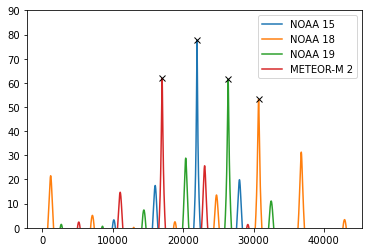

In [67]:
for i,pos in enumerate(altaz):
    alt=pos.alt.degree
    plt.plot(alt,label=sat_tles[sat_ids0[i]][1][0])
    plt.ylim(0,90)
for a in flyovers: plt.plot(a[2],a[4],'kx')
plt.legend()

In [68]:
filename='Sats_'+tstart_isot
print(filename)
np.savez(filename,sat_tles=sat_tles,alt=[pos.alt.degree for pos in altaz],az=[pos.az.degree for pos in altaz],flyovers=flyovers,time=t.isot)

Sats_2022-12-09T12:00:00


In [77]:
d = ascii.read(sourcefname, format="csv")
psrc = SkyCoord(ra=d["ra"], dec=d["dec"], unit=("hourangle", "deg"), frame="icrs")
names = d["name"]

/tmp/ipykernel_256067/1108110744.py:12: RuntimeWarning: divide by zero encountered in true_divide
  X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
/tmp/ipykernel_256067/1108110744.py:13: RuntimeWarning: divide by zero encountered in true_divide
  Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
/tmp/ipykernel_256067/1108110744.py:12: RuntimeWarning: divide by zero encountered in true_divide
  X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
/tmp/ipykernel_256067/1108110744.py:13: RuntimeWarning: divide by zero encountered in true_divide
  Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
/tmp/ipykernel_256067/1108110744.py:12: RuntimeWarning: divide by zero encountered in true_divide
  X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
/tmp/ipykernel_256067/1108110744.py:13: RuntimeWarning: divide by zero encountered in true_divide
  Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
/tmp/ipykernel_256067/1108110744.py:12: RuntimeWarning: divide by zero encountered in true_divide
  X=np.cos(alt)*np.sin(az)/(alt>30/180

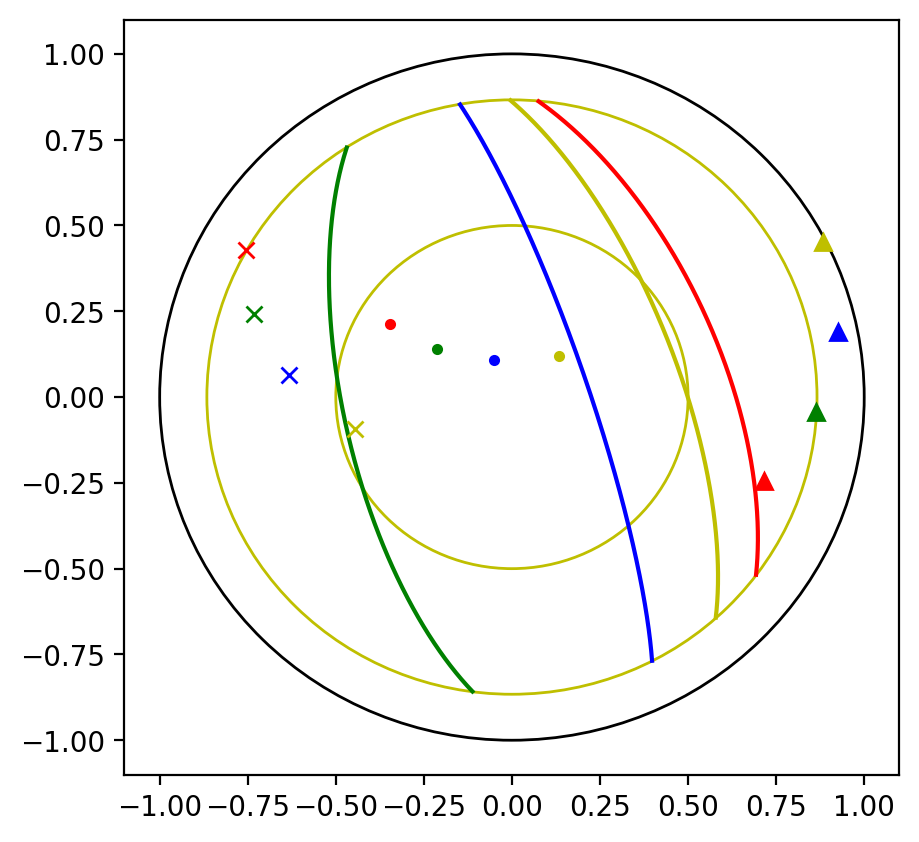

In [84]:
plt.figure(dpi=200,figsize=(5,5))
ax = plt.gca()
ax.add_patch(plt.Circle((0, 0), 1.0, color='k',fill=False))
ax.add_patch(plt.Circle((0, 0), 0.5, color='y',fill=False))
ax.add_patch(plt.Circle((0, 0), np.cos(30/180*np.pi), color='y',fill=False))
colors=['b','r','g','y','c']
symbols=['.','x','^']
for cnt,[satid,satidx,idx,time0,alt0] in enumerate(flyovers):
#    t0=t[idx-100:idx+100].unix-t[idx].unix
    alt=altaz[satidx].alt.rad[idx-200:idx+200]
    az=altaz[satidx].az.rad[idx-200:idx+200]
    X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
    Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
    plt.plot(X,Y,colors[cnt])

    for cnt2,p in enumerate(psrc):
        a = p.transform_to(AltAz(obstime=t[idx], location=loc))
        X=np.cos(a.alt.rad)*np.sin(a.az.rad)
        Y=np.cos(a.alt.rad)*np.cos(a.az.rad)
        plt.plot(X,Y,colors[cnt]+symbols[cnt2])